In [64]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [65]:
df = pd.read_excel("output/data_train.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__longest_strike_below_mean,s1__autocorrelation__lag_8,s1__autocorrelation__lag_3,s1__autocorrelation__lag_9,s1__autocorrelation__lag_4,s1__autocorrelation__lag_7,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_10__k_10,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_11","s1__agg_autocorrelation__f_agg_""var""__maxlag_40","s1__fft_coefficient__attr_""abs""__coeff_12",s1__spkt_welch_density__coeff_2,s1__approximate_entropy__m_2__r_0.1,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,181.804696,1094.717447,1.779954,17,0.085037,0.846710,-0.099622,0.734440,0.266795,17,...,0.238101,-0.342261,46.553048,0.502834,33.749551,1.525904e-03,0.101777,70.649287,0.760144,137.904098
E002,108.654462,1272.111237,1.246933,12,-0.588300,0.675084,-0.785241,0.450297,-0.347499,12,...,0.313434,-0.365200,30.644158,0.478229,276.483695,2.085124e-05,0.145355,45.756098,1.308620,90.775544
E003,198.412419,1042.479529,2.860727,11,-0.671287,0.654112,-0.855068,0.410677,-0.431519,11,...,0.174380,-0.382007,11.951961,0.466444,32.455735,5.641745e-07,0.176679,56.394783,1.134736,0.303491
E004,132.123815,1250.168114,1.338401,20,0.249721,0.877051,0.088855,0.787166,0.403946,19,...,0.255874,-0.331380,8.950125,0.514807,7.036999,3.237022e-03,0.139121,69.819631,0.767338,190.322529
E005,116.803570,1184.972285,1.418379,16,0.009386,0.836367,-0.185819,0.713436,0.204210,16,...,0.202000,-0.359062,14.841333,0.476677,11.629828,1.894488e-04,0.114818,59.082048,0.873224,143.095112


In [66]:
colsY = ["y1", "y2", "y3"]
colsX = [c for c in df.columns if c not in colsY]

X = df[colsX]
Y = df[colsY]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print(Y_train.shape)

(35, 3)


In [67]:
scX = StandardScaler()
X_train_std = scX.fit_transform(X_train)
X_test_std = scX.transform(X_test)

scY = StandardScaler()
Y_train_std = scY.fit_transform(Y_train)
Y_test_std = scY.transform(Y_test)

In [68]:
paramSet = {
    "ex1": {"n_estimators": 10, "learning_rate": 1.0, "max_depth": 2},
    "ex2": {"n_estimators": 50, "learning_rate": 1.0, "max_depth": 3},
    "ex3": {"n_estimators": 50, "learning_rate": 1.0, "max_depth": 10},
    "ex4": {"n_estimators": 50, "learning_rate": 1.0, "max_depth": 1},
    "ex5": {"n_estimators": 100, "learning_rate": 1.0, "max_depth": 1},
    "ex6": {"n_estimators": 200, "learning_rate": 1.0, "max_depth": 1},
}

params = paramSet["ex4"]

In [69]:
base = GradientBoostingRegressor(**params)
# base = SVR(**params)
regressor = MultiOutputRegressor(base)

In [70]:
regressor.fit(X_train_std, Y_train_std)
Y_train_pred = regressor.predict(X_train_std)
Y_test_pred = regressor.predict(X_test_std)

In [71]:
def _residual(ax, y_pred, y, title, color="steelblue"):
    ax.scatter(y_pred, y_pred - y, c=color, marker="o", edgecolor="white", s=70)
    ax.hlines(y=0, xmin=-10, xmax=50, color="black", lw=2)
    ax.axes.set_aspect("equal")
    ax.set_title(title)


def plot_res(y_train, y_test, y_train_pred, y_test_pred):
    fig, ax = plt.subplots(
        1, 2, figsize=(9, 3), constrained_layout=True, sharex=True, sharey=True
    )
    _residual(ax=ax[0], y_pred=y_train_pred, y=y_train, title="Train")
    _residual(ax=ax[1], y_pred=y_test_pred, y=y_test, title="Test", color="limegreen")
    ax[0].set_xlim([-2, 2])
    fig.supxlabel("Predicted values")
    fig.supylabel("Residual")


def store_results(y_train, y_test, y_train_pred, y_test_pred):
    MSE_train = mean_squared_error(y_train, y_train_pred)
    MSE_test = mean_squared_error(y_test, y_test_pred)

    R2_train = r2_score(y_train, y_train_pred)
    R2_test = r2_score(y_test, y_test_pred)

    data = {
        "MSE Train": MSE_train,
        "MSE Test": MSE_test,
        "R2 Train": R2_train,
        "R2 Test": R2_test,
    }
    return data

,MSE Train,MSE Test,R2 Train,R2 Test
0,0.000029,0.484197,0.999971,0.286879
1,0.000040,0.375669,0.999960,0.460944
2,0.000010,0.209308,0.999990,0.766845


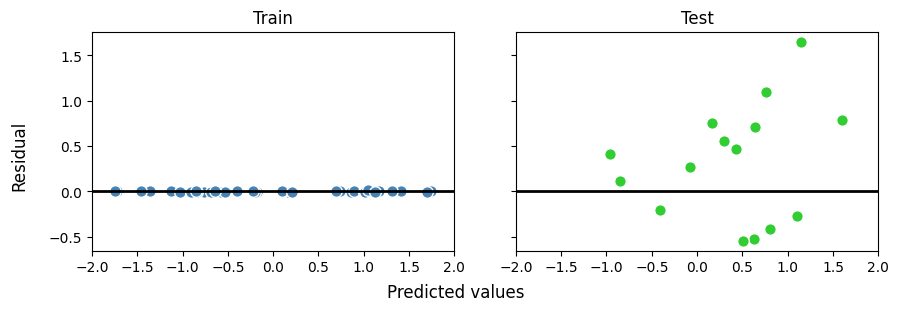

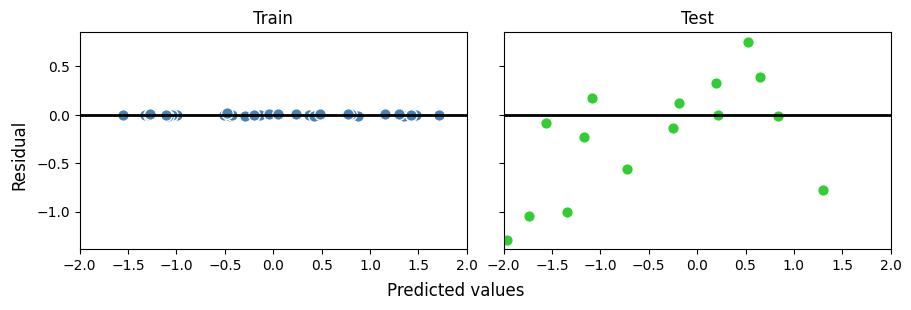

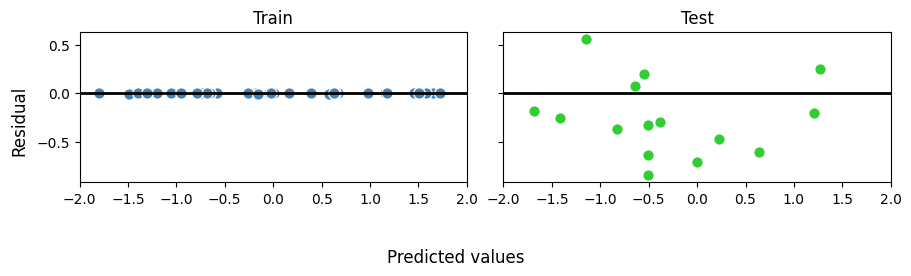

In [72]:
resArr = []
for i in range(Y.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred)
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes


In [ ]:
dfFi = pd.DataFrame(data={"feature": X.columns.values})
estimators = regressor.estimators_
for i in range(len(estimators)):
    fi = estimators[i].feature_importances_
    dfFi[f"importance_{i+1}"] = fi

dfFi

,feature,importance_1,importance_2,importance_3
0,m1,0.047949,0.000000,0.007688
1,m2,0.001790,0.105787,0.005155
2,m3,0.008282,0.043131,0.070373
3,s1__longest_strike_below_mean,0.000000,0.000000,0.000000
4,s1__autocorrelation__lag_8,0.000000,0.000000,0.000000
5,s1__autocorrelation__lag_3,0.000000,0.000000,0.000000
6,s1__autocorrelation__lag_9,0.000000,0.000000,0.000000
7,s1__autocorrelation__lag_4,0.000969,0.000000,0.000000
8,s1__autocorrelation__lag_7,0.000000,0.000000,0.000005
9,s1__longest_strike_above_mean,0.000000,0.000000,0.000000
